# SPY and VXX 2020

The [`spy.csv`](https://aef.me/lab/files/data/spy.csv) and [`vxx.csv`](https://aef.me/lab/files/data/vxx.csv) files contain the per-minute OHLCV data for the SPY and VXX ETFs for the year 2020.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# data is batched every 2 months
if not os.path.exists("spy.csv") or not os.path.exists("vxx.csv"):
    names = ["datetime", "open", "high", "low", "close", "volume"]
    usecols = [0, 1, 2, 3, 4, 7]

    spy = pd.concat(
        [
            pd.read_csv(
                f"spy_{i}.csv",
                header=0,
                names=names,
                usecols=usecols,
            )
            for i in range(1, 7)
        ],
        ignore_index=True,
    )
    vxx = pd.concat(
        [
            pd.read_csv(
                f"vxx_{i}.csv",
                header=0,
                names=names,
                usecols=usecols,
            )
            for i in range(1, 7)
        ],
        ignore_index=True,
    )

    # sort by datetime ascending
    spy["datetime"] = pd.to_datetime(spy["datetime"])
    vxx["datetime"] = pd.to_datetime(vxx["datetime"])
    spy.sort_values(by="datetime", ascending=True, inplace=True)
    vxx.sort_values(by="datetime", ascending=True, inplace=True)

    # index by datetime
    spy.set_index("datetime", inplace=True)
    vxx.set_index("datetime", inplace=True)

    # get missing VXX rows
    missing = spy.index.difference(vxx.index)

    # missing means 0 volume
    for i in missing:
        # get the last row and carry over OHLC
        last_row = vxx.loc[vxx.index < i].iloc[-1]
        vxx.loc[i] = last_row[["open", "high", "low", "close"]]
        vxx.at[i, "volume"] = 0

    # ensure volume is an int
    vxx["volume"] = vxx["volume"].astype(int)

    # reset index
    spy.reset_index(inplace=True)
    vxx.reset_index(inplace=True)

    # serialize in ISO-8601
    spy["datetime"] = spy["datetime"].dt.strftime("%Y-%m-%dT%H:%M:%S")
    vxx["datetime"] = vxx["datetime"].dt.strftime("%Y-%m-%dT%H:%M:%S")

    # delete if exists
    if os.path.exists("spy.csv"):
        os.remove("spy.csv")
    if os.path.exists("vxx.csv"):
        os.remove("vxx.csv")

    # write to csv
    spy.to_csv("spy.csv", index=False)
    vxx.to_csv("vxx.csv", index=False)

In [3]:
# spy = pd.read_csv("spy.csv")
# vxx = pd.read_csv("vxx.csv")
spy = pd.read_csv("https://lab.aef.me/files/data/spy.csv")
vxx = pd.read_csv("https://lab.aef.me/files/data/vxx.csv")

In [4]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98235 entries, 0 to 98234
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  98235 non-null  object 
 1   open      98235 non-null  float64
 2   high      98235 non-null  float64
 3   low       98235 non-null  float64
 4   close     98235 non-null  float64
 5   volume    98235 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.5+ MB


In [5]:
vxx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98235 entries, 0 to 98234
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  98235 non-null  object 
 1   open      98235 non-null  float64
 2   high      98235 non-null  float64
 3   low       98235 non-null  float64
 4   close     98235 non-null  float64
 5   volume    98235 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.5+ MB


In [6]:
# set datetime as index
spy["datetime"] = pd.to_datetime(spy["datetime"])
vxx["datetime"] = pd.to_datetime(vxx["datetime"])
spy.set_index("datetime", inplace=True)
vxx.set_index("datetime", inplace=True)

# resample to daily close
spy = spy.resample("D").agg(
    {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }
)
vxx = vxx.resample("D").agg(
    {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }
)

# drop days with 0 volume (market closed)
spy = spy[spy["volume"] != 0]
vxx = vxx[vxx["volume"] != 0]

In [7]:
spy.head()

,open,high,low,close,volume
datetime,,,,,
2020-01-02,323.54,324.85,322.53,324.84,39870707
2020-01-03,321.16,323.64,321.10,322.44,46708413
2020-01-06,320.49,323.73,320.36,323.67,35171161
2020-01-07,323.02,323.54,322.24,322.76,27567976
2020-01-08,322.94,325.78,322.67,324.42,45832441


In [8]:
vxx.head()

,open,high,low,close,volume
datetime,,,,,
2020-01-02,235.36,240.640,232.00,232.3200,1622782
2020-01-03,250.72,251.840,239.20,244.4800,2748282
2020-01-06,251.84,252.648,241.28,241.3600,1504013
2020-01-07,242.56,245.760,237.60,240.3200,1542142
2020-01-08,238.56,240.000,229.28,235.5216,2742817


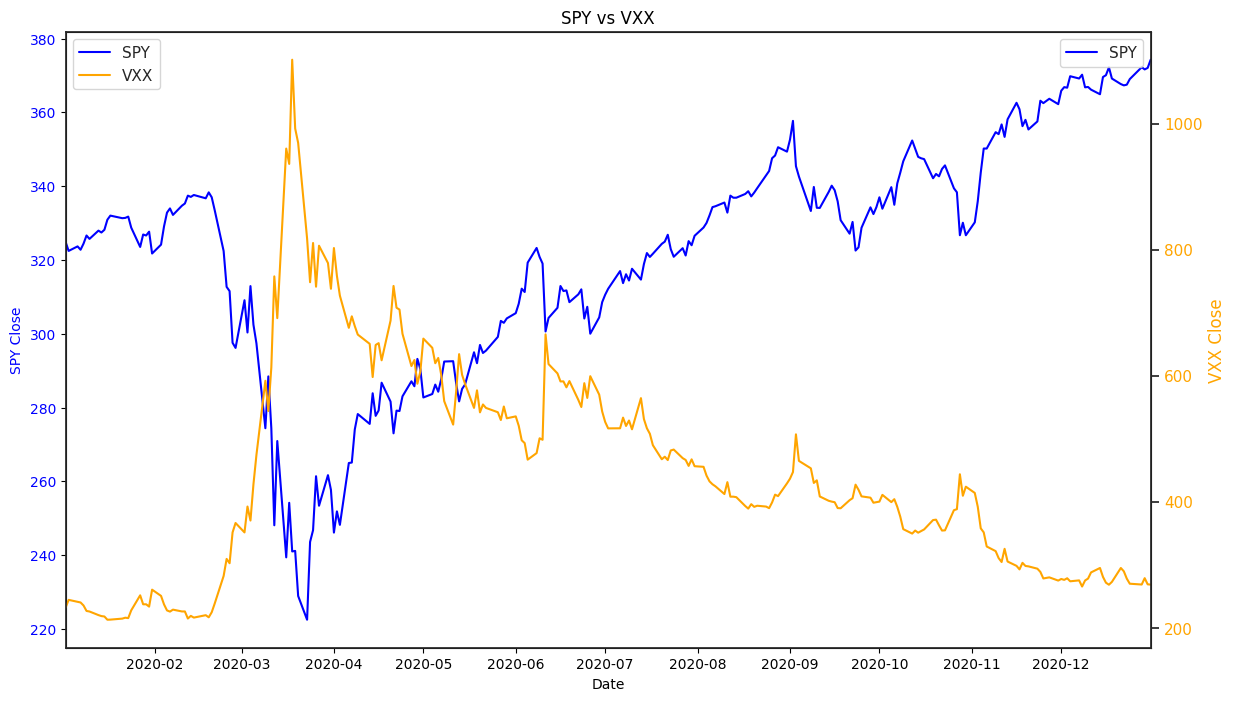

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.set_xlim(spy.index[0], spy.index[-1])
ax1.set_xlabel("Date")
ax1.set_ylabel("SPY Close", color="blue")
ax1.set_title("SPY vs VXX")
ax1.tick_params(axis="y", labelcolor="blue")

sns.set_theme(style="ticks")
sns.lineplot(
    spy,
    x=spy.index,
    y="close",
    ax=ax1,
    color="blue",
    label="SPY",
)

ax2 = ax1.twinx()
ax2.set_ylabel("VXX Close", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

sns.lineplot(
    vxx,
    x=vxx.index,
    y="close",
    ax=ax2,
    color="orange",
    label="VXX",
)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper left",
)

plt.show()